# K-vecinos más cercanos (KDtree & KNN)
## Importación de bibliotecas

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos de clientes bancarios: crédito

In [63]:
# Leer la base de datos
clients = pd.read_csv("./Assets/dataBaseElements200.csv")
print("**Base de datos de clientes del banco que sacaron un crédito")
print("------------------------------------------------------------")
clients

**Base de datos de clientes del banco que sacaron un crédito
------------------------------------------------------------


,Edad,Credito,Cumplio
0,60,100667,0
1,20,135319,1
2,45,462800,0
3,19,509836,0
4,59,262093,1
...,...,...,...
195,57,67337,1
196,48,347142,0
197,26,336357,1
198,40,522887,1


## Clientes Pagadores VS Deudores

In [64]:
# Filtrar clientes buenos y malos (clientes pagadores vs clientes deudores)
goodCustomers = clients[clients["Cumplio"] == 1]
badCustomers = clients[clients["Cumplio"] == 0]

print("**Clientes que cumplieron y NO cumplieron pagando el crédito")
print("------------------------------------------------------------")
goodCustomers, badCustomers,

**Clientes que cumplieron y NO cumplieron pagando el crédito
------------------------------------------------------------


(     Edad  Credito  Cumplio
 1      20   135319        1
 4      59   262093        1
 6      30   565252        1
 7      39    72692        1
 8      22   366972        1
 ..    ...      ...      ...
 188    21   136102        1
 194    34   422720        1
 195    57    67337        1
 197    26   336357        1
 198    40   522887        1
 
 [99 rows x 3 columns],
      Edad  Credito  Cumplio
 0      60   100667        0
 2      45   462800        0
 3      19   509836        0
 5      56   491736        0
 9      48   555228        0
 ..    ...      ...      ...
 191    28   536269        0
 192    25    76501        0
 193    53   514235        0
 196    48   347142        0
 199    40    98794        0
 
 [101 rows x 3 columns])

## Gráfica de dispersión: Clientes Pagadores VS Deudores

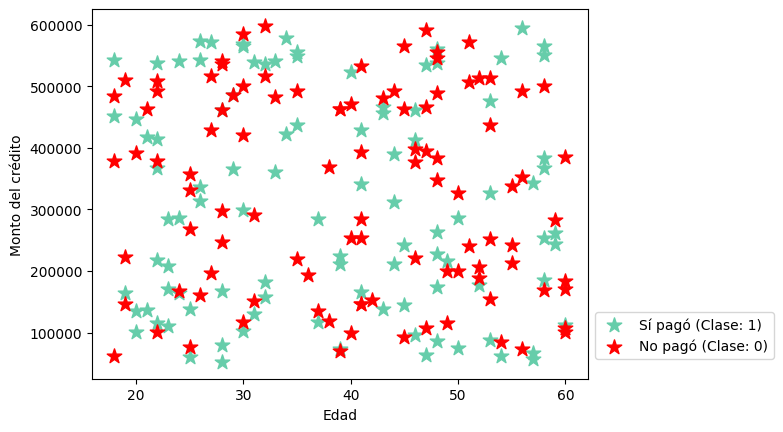

In [65]:
# Grafico de dispersión de clientes buenos y malos (clientes pagadores vs clientes deudores)
plt.scatter(goodCustomers["Edad"], goodCustomers["Credito"],
            marker="*", s=120, color="mediumaquamarine", label="Sí pagó (Clase: 1)")

plt.scatter(badCustomers["Edad"], badCustomers["Credito"],
            marker="*", s=120, color="red", label="No pagó (Clase: 0)")

plt.ylabel("Monto del crédito")
plt.xlabel("Edad")
plt.legend(bbox_to_anchor=(1, 0.2))
plt.show()

## Preparación de los datos (Escalar en un rango de 0 y 1)

In [66]:
# Preparar los datos
dataClients = clients[["Edad", "Credito"]].values
classClient = clients["Cumplio"].values

# Escalar los datos (escalar los datos para que estén en el rango [0, 1]. Esto es importante para que las diferentes características tengan la misma importancia en el cálculo de la distancia)
dataScaled = (dataClients - dataClients.min(axis=0)) / (dataClients.max(axis=0) - dataClients.min(axis=0))

print("**Mostrar los datos escalados")
print("-----------------------------")
dataScaled

**Mostrar los datos escalados
-----------------------------


array([[1.        , 0.08872444],
       [0.04761905, 0.15221394],
       [0.64285714, 0.75222567],
       [0.02380952, 0.83840518],
       [0.97619048, 0.38448967],
       [0.9047619 , 0.8052423 ],
       [0.28571429, 0.93993855],
       [0.5       , 0.03746855],
       [0.0952381 , 0.5766493 ],
       [0.71428571, 0.92157254],
       [0.69047619, 0.75915689],
       [0.95238095, 0.94120094],
       [0.19047619, 0.89760183],
       [0.33333333, 0.85217418],
       [0.21428571, 0.68885343],
       [0.28571429, 0.97541   ],
       [0.        , 0.89930211],
       [0.11904762, 0.21843526],
       [0.64285714, 0.93894549],
       [0.47619048, 0.12074036],
       [0.19047619, 0.47902219],
       [0.61904762, 0.61850415],
       [0.47619048, 0.58142036],
       [0.33333333, 1.        ],
       [0.66666667, 0.66141802],
       [0.92857143, 0.53252802],
       [0.28571429, 0.09305393],
       [0.14285714, 0.20959488],
       [0.11904762, 0.10594898],
       [0.26190476, 0.79582661],
       [0.

## Implementación del KD-Tree y KNN

In [67]:
# Definir una estructura de datos llamada KDNode para representar nodos en el KD-Tree. Luego, implementamos las funciones build_kdtree y knn_search para construir el KD-Tree y buscar vecinos cercanos en él, respectivamente. 
class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point # El punto de datos que este nodo representa
        self.axis = axis #  El eje a lo largo del cual se realizará la división en el árbol
        self.left = left # Referencia al nodo hijo izquierdo
        self.right = right # Referencia al nodo hijo derecho

# Definir una función build_kdtree que construye el KD-Tree recursivamente. El KD-Tree divide los datos en cada nivel a lo largo de un eje específico y construye subárboles en función de los valores medianos de los datos.
def build_kdtree(points, depth=0):
    if len(points) == 0:
        # Si no hay puntos, retorna None, lo cual indica que este es un nodo hoja vacío
        return None
    # Calcula el eje actual de división usando depth % len(points[0]). depth es la profundidad actual en el árbol y se alterna entre los ejes.
    # Ordena los puntos a lo largo del eje actual.
    # Encuentra el punto mediano y crea un nodo KDNode con ese punto y eje.
    # Recursivamente construye el subárbol izquierdo con los puntos antes del mediano y el subárbol derecho con los puntos después del mediano.
    axis = depth % len(points[0])
    points = points.tolist()
    points.sort(key=lambda point: point[axis])
    median = len(points) // 2
    return KDNode(np.array(points[median]), axis,
                  build_kdtree(np.array(points[:median]), depth + 1),
                  build_kdtree(np.array(points[median + 1:]), depth + 1))

In [68]:
# Definir una función knn_search que realiza una búsqueda de k vecinos más cercanos en el KD-Tree. Utiliza una búsqueda recursiva para encontrar los vecinos más cercanos.
def knn_search(node, point, k=1):
    def recursive_search(node, point, k, nearest):
        if node is None:
            return
        distance = np.linalg.norm(point - node.point)
        if len(nearest) < k:
            nearest.append((distance, node.point))
            nearest.sort(key=lambda x: x[0])
        elif distance < nearest[-1][0]:
            nearest.pop()
            nearest.append((distance, node.point))
            nearest.sort(key=lambda x: x[0])
        
        axis_distance = point[node.axis] - node.point[node.axis]
        closer_node, farther_node = (node.left, node.right) if axis_distance <= 0 else (node.right, node.left)
        
        recursive_search(closer_node, point, k, nearest)
        if abs(axis_distance) < nearest[-1][0]:
            recursive_search(farther_node, point, k, nearest)
    
    nearest_points = []
    recursive_search(node, point, k, nearest_points)
    return [point for _, point in nearest_points]

# Construir el KD-Tree utilizando los datos escalados. El KD-Tree es una estructura que organiza los datos de manera que las búsquedas de vecinos cercanos sean más eficientes
kdtree = build_kdtree(dataScaled)

## Analizando nuevo solicitante

Pertenece a la clase: 1
Probabilidades por clase: 0.75 0.25


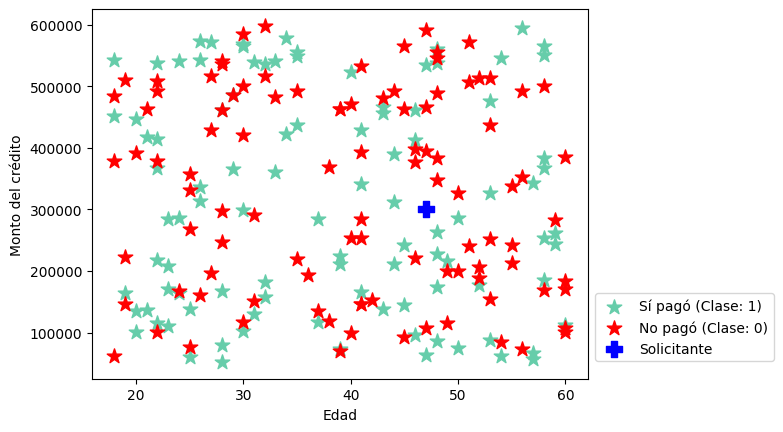

In [69]:
# Datos del nuevo solicitante y los escalamos de manera similar a los datos originales
ageApplicant = 47
creditApplicant = 300000
applicant = np.array([ageApplicant, creditApplicant])
applicant_scaled = (applicant - dataClients.min(axis=0)) / (dataClients.max(axis=0) - dataClients.min(axis=0))

# Realizar la búsqueda KNN en el KD-Tree para el nuevo solicitante
k = 4
nearest_neighbors = knn_search(kdtree, applicant_scaled, k)

# Obtener los índices de los vecinos más cercanos en los datos escalados y calculamos la clase y las probabilidades para el nuevo solicitante
nearest_indices = [np.where((dataScaled == neighbor).all(axis=1))[0][0] for neighbor in nearest_neighbors]
predicted_class = sum(classClient[index] for index in nearest_indices) / k
print("Pertenece a la clase:", round(predicted_class))
print("Probabilidades por clase:", predicted_class, 1 - predicted_class)

# Graficar resultados con el nuevo solicitante
plt.scatter(goodCustomers["Edad"], goodCustomers["Credito"],
            marker="*", s=120, color="mediumaquamarine", label="Sí pagó (Clase: 1)")

plt.scatter(badCustomers["Edad"], badCustomers["Credito"],
            marker="*", s=120, color="red", label="No pagó (Clase: 0)")

plt.scatter(ageApplicant, creditApplicant, marker="P", s=120, color="blue", label="Solicitante")

plt.ylabel("Monto del crédito")
plt.xlabel("Edad")
plt.legend(bbox_to_anchor=(1, 0.25))
plt.show()

Métricas de evaluación:
Precisión: 0.75
Recall: 0.75
F1-Score: 0.75


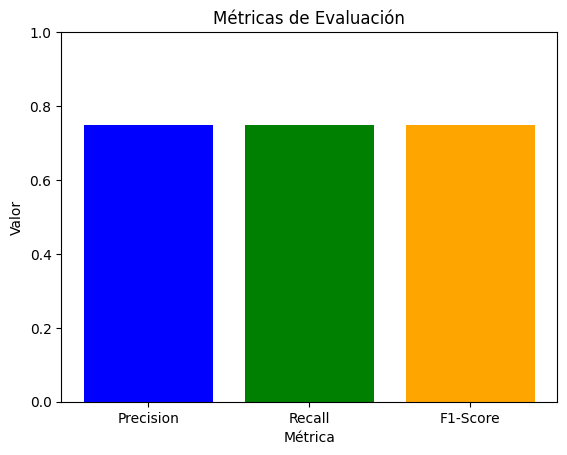

In [70]:
# Calcular las métricas
true_positive = sum(classClient[index] for index in nearest_indices)
false_positive = k - true_positive
false_negative = sum(1 - classClient[index] for index in nearest_indices)

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimir las métricas
print("Métricas de evaluación:")
print("Precisión:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Graficar las métricas
labels = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1_score]

plt.bar(labels, scores, color=['blue', 'green', 'orange'])
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.title('Métricas de Evaluación')
plt.ylim(0, 1)  # Ajusta el rango del eje y para las métricas entre 0 y 1
plt.show()